# Импорт зависимостей

In [ ]:
!pip install vk_api scheme networkx matplotlib pandas seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
from urllib.request import urlretrieve
import os
import time
import math
import vk_api
from urllib.request import urlretrieve
from tqdm import tqdm
import shutil
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter

получение токена

In [ ]:
#https://vk.com/app52817297
# Авторизация
# Укажите access_token с необходимыми правами доступа (photos, groups)
access_token = '229af227229af227229af2275b21bf1fb62229a229af22745c9ab1990b9211756fda5e3'  # Вставьте сюда ваш токен

# Задача 1.
Используя API VK (https://vk.com/dev), загрузить все фотографии (указанного размера) из всех альбомов указанной группы. За основу взять скрипт из вложения. (3 балла)

In [ ]:
# Создаем сессию
vk_session = vk_api.VkApi(token=access_token)
vkapi = vk_session.get_api()

# ID группы (отрицательное значение для группы)
group_id = -191692151  # Указанная группа

# Размер изображений для загрузки (например, "x" - 604px по большей стороне)
desired_size = "x"

# Максимальное количество фотографий для скачивания из одного альбома
MAX_PHOTOS_PER_ALBUM = 10

# Получаем список альбомов группы
albums = vkapi.photos.getAlbums(owner_id=group_id)
if not albums["items"]:
    print("Альбомы не найдены.")
    exit()

# Создаем папку для сохранения всех альбомов
if not os.path.exists('saved'):
    os.mkdir('saved')

# Подсчет общего количества фотографий для прогресс-бара
total_photos_to_download = min(MAX_PHOTOS_PER_ALBUM * len(albums["items"]),
                                sum(min(album["size"], MAX_PHOTOS_PER_ALBUM) for album in albums["items"]))

# Подготовка общего прогресс-бара
total_progress_bar = tqdm(
    total=total_photos_to_download,
    desc="Общий прогресс скачивания",
    unit="фото",
    colour="green"
)

# Счетчик общего количества скачанных фотографий
total_downloaded_photos = 0

# Обработка каждого альбома
for album in albums["items"]:
    album_id = album["id"]
    album_title = album["title"].replace("/", "_")  # На случай, если в названии есть запрещенные символы
    photo_folder = f'saved/album_{album_id}_{album_title}'

    if not os.path.exists(photo_folder):
        os.mkdir(photo_folder)

    print(f"\nОбрабатываем альбом: {album_title}")
    photos_count = album["size"]
    counter = 0  # Текущий счетчик
    breaked = 0  # Не удалось загрузить
    time_now = time.time()  # Время старта загрузки

    # Загрузка фотографий из альбома
    for j in range(math.ceil(photos_count / 1000)):  # Порционно получаем фотографии (до 1000 за раз)
        photos = vkapi.photos.get(owner_id=group_id, album_id=album_id, count=1000, offset=j*1000)

        for photo in photos["items"]:
            # Проверяем лимит скачанных фотографий для альбома
            if counter >= MAX_PHOTOS_PER_ALBUM:
                break

            counter += 1
            # Ищем URL изображения заданного размера
            url = next((size["url"] for size in photo["sizes"] if size["type"] == desired_size), None)
            if not url:
                total_progress_bar.set_description(f"Альбом {album_title} (пропуск)")
                total_progress_bar.update(1)
                breaked += 1
                continue

            try:
                filename = os.path.join(photo_folder, os.path.basename(url))
                urlretrieve(url, filename)  # Загружаем и сохраняем файл

                # Обновляем общий прогресс-бар
                total_progress_bar.update(1)
                total_downloaded_photos += 1
            except Exception as e:
                total_progress_bar.set_description(f"Альбом {album_title} (ошибка)")
                total_progress_bar.update(1)
                breaked += 1
                continue

        # Проверяем лимит скачанных фотографий для альбома
        if counter >= MAX_PHOTOS_PER_ALBUM:
            break

# Закрываем общий прогресс-бар
total_progress_bar.close()

print(f"\nЗагрузка завершена. Всего скачано фотографий: {total_downloaded_photos}")

Общий прогресс скачивания:   0%|          | 0/560 [00:00<?, ?фото/s]


Обрабатываем альбом: Серебрянский камень 9-10.11.2024


Общий прогресс скачивания:   2%|▏         | 10/560 [00:12<10:19,  1.13s/фото]


Обрабатываем альбом: Турнир по бильярду 31.10.2024


Общий прогресс скачивания:   4%|▎         | 20/560 [00:22<09:27,  1.05s/фото]


Обрабатываем альбом: г. Сапог и Усьвинские столбы 20.09.2024


Общий прогресс скачивания:   5%|▌         | 30/560 [00:33<08:49,  1.00фото/s]


Обрабатываем альбом: Большой Шелом 21-22.09.2024


Общий прогресс скачивания:   7%|▋         | 40/560 [00:44<09:15,  1.07s/фото]


Обрабатываем альбом: КОТ 15.09.2024


Общий прогресс скачивания:   9%|▉         | 50/560 [00:55<09:20,  1.10s/фото]


Обрабатываем альбом: Первая встреча 13.09.2024


Общий прогресс скачивания:  11%|█         | 60/560 [01:06<08:48,  1.06s/фото]


Обрабатываем альбом: Ярмарка студенческих организаций 12.09.2024


Общий прогресс скачивания:  12%|█▎        | 70/560 [01:16<08:25,  1.03s/фото]


Обрабатываем альбом: Сплав Ай 25-28.07.24


Общий прогресс скачивания:  14%|█▍        | 80/560 [01:27<07:54,  1.01фото/s]


Обрабатываем альбом: Выпускной Турклуба 2024


Общий прогресс скачивания:  16%|█▌        | 90/560 [01:37<07:53,  1.01s/фото]


Обрабатываем альбом: Таганай - Тургояк 30.05-02.06.2024


Общий прогресс скачивания:  18%|█▊        | 100/560 [01:48<08:18,  1.08s/фото]


Обрабатываем альбом: Оленьи Ручьи 16-17.03.2024


Общий прогресс скачивания:  20%|█▉        | 110/560 [01:59<08:13,  1.10s/фото]


Обрабатываем альбом: Помяненный камень, Ветлан 24.02.2024


Общий прогресс скачивания:  21%|██▏       | 120/560 [02:09<07:38,  1.04s/фото]


Обрабатываем альбом: Усть-Койва 18-19.11.2023


Общий прогресс скачивания:  23%|██▎       | 130/560 [02:20<07:19,  1.02s/фото]


Обрабатываем альбом: Ветлан Полюд 22.10.2023


Общий прогресс скачивания:  25%|██▌       | 140/560 [02:30<07:11,  1.03s/фото]


Обрабатываем альбом: Иремель 23 - 24.09.23


Общий прогресс скачивания:  27%|██▋       | 150/560 [02:41<07:09,  1.05s/фото]


Обрабатываем альбом: КОТ 17.09.2023


Общий прогресс скачивания:  29%|██▊       | 160/560 [02:52<06:32,  1.02фото/s]


Обрабатываем альбом: День Рождения Турклуба – 5 лет


Общий прогресс скачивания:  30%|███       | 170/560 [03:02<06:11,  1.05фото/s]


Обрабатываем альбом: Сплав Юрюзань 3-6.08.2023


Общий прогресс скачивания:  32%|███▏      | 180/560 [03:12<06:37,  1.05s/фото]


Обрабатываем альбом: Таганай 13-15.05.23


Общий прогресс скачивания:  34%|███▍      | 190/560 [03:23<06:13,  1.01s/фото]


Обрабатываем альбом: Каменный город Шумихинские скалы 26.03.23


Общий прогресс скачивания:  36%|███▌      | 200/560 [03:34<06:22,  1.06s/фото]


Обрабатываем альбом: Нургуш 24-25.09.22


Общий прогресс скачивания:  38%|███▊      | 210/560 [03:44<06:08,  1.05s/фото]


Обрабатываем альбом: КОТ 18.09.22


Общий прогресс скачивания:  39%|███▉      | 220/560 [03:56<06:11,  1.09s/фото]


Обрабатываем альбом: Усьвинские столбы- Губаха 14 августа


Общий прогресс скачивания:  41%|████      | 230/560 [04:07<05:55,  1.08s/фото]


Обрабатываем альбом: Сплав Вишера 20-24.07.2022


Общий прогресс скачивания:  43%|████▎     | 240/560 [04:18<05:41,  1.07s/фото]


Обрабатываем альбом: ПВД «Оленьи ручьи» 16-17.04.22


Общий прогресс скачивания:  45%|████▍     | 250/560 [04:29<05:41,  1.10s/фото]


Обрабатываем альбом: Иремель 25-26.09.21


Общий прогресс скачивания:  46%|████▋     | 260/560 [04:40<05:49,  1.17s/фото]


Обрабатываем альбом: КОТ 19.09.2021


Общий прогресс скачивания:  48%|████▊     | 270/560 [04:52<05:18,  1.10s/фото]


Обрабатываем альбом: Сплав по р. Ай - 22-25.08.2021


Общий прогресс скачивания:  50%|█████     | 280/560 [05:02<04:38,  1.01фото/s]


Обрабатываем альбом: Курс первой помощи 19-20.06.2021


Общий прогресс скачивания:  52%|█████▏    | 290/560 [05:11<04:06,  1.09фото/s]


Обрабатываем альбом: Арчери Таг 30.04.21


Общий прогресс скачивания:  54%|█████▎    | 300/560 [05:24<05:51,  1.35s/фото]


Обрабатываем альбом: Скалодром 16.04.2021


Общий прогресс скачивания:  55%|█████▌    | 310/560 [05:36<05:06,  1.23s/фото]


Обрабатываем альбом: Каменный город, Усьвинские столбы 13, 14.03.2021


Общий прогресс скачивания:  57%|█████▋    | 320/560 [05:47<04:24,  1.10s/фото]


Обрабатываем альбом: Оленьи ручьи 13-14.02.2021


Общий прогресс скачивания:  59%|█████▉    | 330/560 [05:57<03:51,  1.01s/фото]


Обрабатываем альбом: Иремель 6-8.11.20


Общий прогресс скачивания:  61%|██████    | 340/560 [06:08<03:48,  1.04s/фото]


Обрабатываем альбом: ПВД 03 - 04.10.20 Ветлан, Полюд, Помяненный


Общий прогресс скачивания:  62%|██████▎   | 350/560 [06:20<03:54,  1.12s/фото]


Обрабатываем альбом: КОТ 2020


Общий прогресс скачивания:  64%|██████▍   | 360/560 [06:30<03:35,  1.08s/фото]


Обрабатываем альбом: Сплав по Вишере - 5-9.08.2020


Общий прогресс скачивания:  66%|██████▌   | 370/560 [06:41<03:15,  1.03s/фото]


Обрабатываем альбом: СОС 2020 - соревнование по ориентированию и сплав


Общий прогресс скачивания:  68%|██████▊   | 380/560 [06:52<03:17,  1.10s/фото]


Обрабатываем альбом: ПВД 07.03.2020 Качканар


Общий прогресс скачивания:  70%|██████▉   | 390/560 [07:03<02:55,  1.04s/фото]


Обрабатываем альбом: Валентинки 14.02.20


Общий прогресс скачивания:  71%|███████▏  | 400/560 [07:13<02:42,  1.02s/фото]


Обрабатываем альбом: ПВД 02.02.2020 Помяненный


Общий прогресс скачивания:  73%|███████▎  | 410/560 [07:24<02:39,  1.06s/фото]


Обрабатываем альбом: ПВД 16.11.19 Колпаки и Чусовой 


Общий прогресс скачивания:  75%|███████▌  | 420/560 [07:34<02:19,  1.00фото/s]


Обрабатываем альбом: ПВД 05 - 06.10.19 Ветлан, Полюд, Поменянный 


Общий прогресс скачивания:  77%|███████▋  | 430/560 [07:44<02:08,  1.01фото/s]


Обрабатываем альбом: Тренировка навыков на Динамо 28.09.19


Общий прогресс скачивания:  79%|███████▊  | 440/560 [07:55<02:07,  1.06s/фото]


Обрабатываем альбом: Сплав р. Койва 2019


Общий прогресс скачивания:  80%|████████  | 450/560 [08:05<01:52,  1.02s/фото]


Обрабатываем альбом: ПВД 02-03.03.2019 Усть-Койва


Общий прогресс скачивания:  82%|████████▏ | 460/560 [08:16<01:42,  1.02s/фото]


Обрабатываем альбом: Встреча 25.02.19


Общий прогресс скачивания:  84%|████████▍ | 470/560 [08:26<01:25,  1.05фото/s]


Обрабатываем альбом: Sky trip 15.02.2019


Общий прогресс скачивания:  86%|████████▌ | 480/560 [08:38<01:28,  1.10s/фото]


Обрабатываем альбом: Встреча 11.02.19


Общий прогресс скачивания:  88%|████████▊ | 490/560 [08:48<01:10,  1.01s/фото]


Обрабатываем альбом: ПВД 02.02.19 Качканар


Общий прогресс скачивания:  89%|████████▉ | 500/560 [08:58<00:59,  1.00фото/s]


Обрабатываем альбом: ПВД 10.11.18 Усьвинские столбы и Каменный город


Общий прогресс скачивания:  91%|█████████ | 510/560 [09:08<00:49,  1.02фото/s]


Обрабатываем альбом: Встреча 28.01.19


Общий прогресс скачивания:  93%|█████████▎| 520/560 [09:18<00:40,  1.00s/фото]


Обрабатываем альбом: Встреча 14.01.19


Общий прогресс скачивания:  95%|█████████▍| 530/560 [09:27<00:27,  1.09фото/s]


Обрабатываем альбом: Каток 30.11.18


Общий прогресс скачивания:  96%|█████████▋| 540/560 [09:37<00:18,  1.09фото/s]


Обрабатываем альбом: Скалодром 25.11.18


Общий прогресс скачивания:  98%|█████████▊| 550/560 [09:48<00:10,  1.03s/фото]


Обрабатываем альбом: ПВД 13-14.10.2018 Полюд и Ветлан


Общий прогресс скачивания: 100%|██████████| 560/560 [09:58<00:00,  1.07s/фото]


Обрабатываем альбом: Untitled

Загрузка завершена. Всего скачано фотографий: 560


In [ ]:
def archive_folder(folder_path, archive_name=None):
    # Если имя архива не указано, используем имя папки
    if archive_name is None:
        archive_name = os.path.basename(folder_path)

    # Полный путь к zip-архиву
    zip_path = f"{folder_path}.zip"

    # Создание zip-архива
    shutil.make_archive(
        folder_path,  # Базовое имя архива
        'zip',        # Формат архива
        os.path.dirname(folder_path),  # Родительская директория
        os.path.basename(folder_path)  # Имя архивируемой папки
    )

    print(f"Архив создан: {zip_path}")
    return zip_path

# Использование
archive_path = archive_folder('/content/saved')

Архив создан: /content/saved.zip


# Задача 2.
Анализ групп ВК

1. Выбрать две группы ВК для исследования (более 1000 подписчиков). Проанализировать данные об их подписчиках (возраст, пол и т.д.).  (3 балла)
  *   Общежитие НИУ ВШЭ – Пермь (https://vk.com/dormitory.hse.perm)
  *   Турклуб ВШЭ - Пермь (https://vk.com/tkhse_perm)

2. Разработать методику сравнения групп между собой (пересечение пользователей, регион и т.д.). Построить иллюстрирующие графики. (2 балла)

3. Визуализировать граф (NetworkX — NetworkX documentation) пользователей групп из пункта 1. (3 балла)



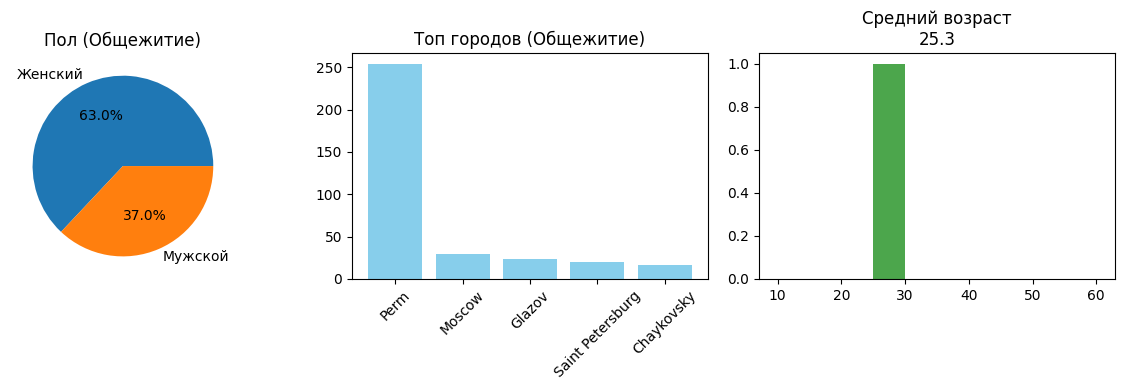

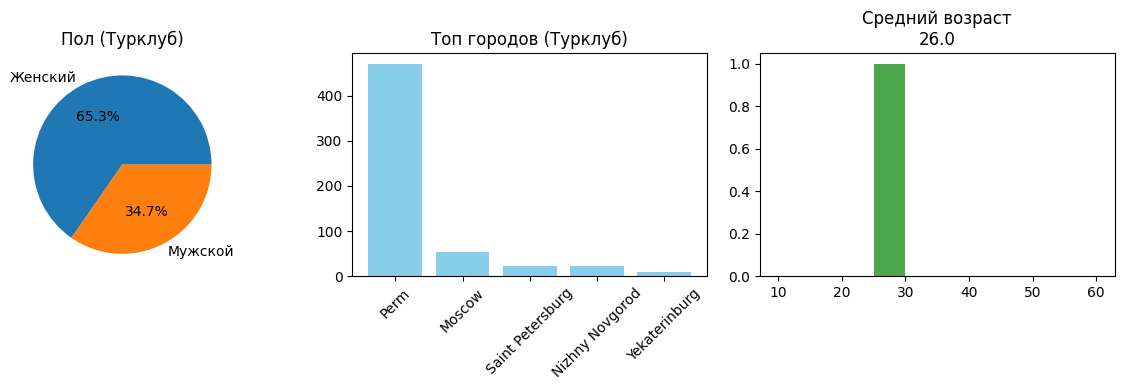

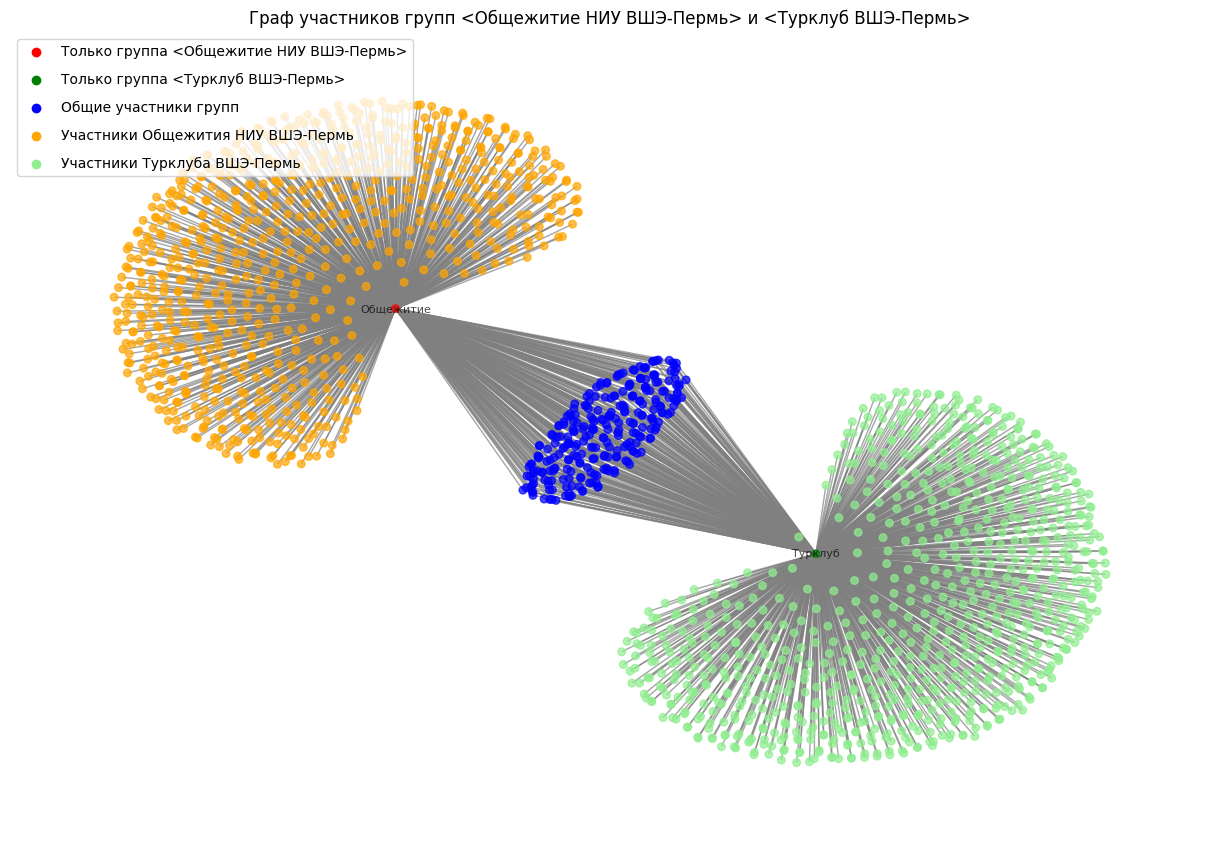


Статистика групп:

Общежитие:
Распределение по полу: {'Женский': 645, 'Мужской': 379}
Средний возраст: 25.34108527131783
Топ городов: {'Perm': 254, 'Moscow': 29, 'Glazov': 24, 'Saint Petersburg': 20, 'Chaykovsky': 16}

Турклуб:
Распределение по полу: {'Женский': 716, 'Мужской': 380}
Средний возраст: 26.01392757660167
Топ городов: {'Perm': 471, 'Moscow': 53, 'Saint Petersburg': 22, 'Nizhny Novgorod': 22, 'Yekaterinburg': 9}

Общее количество общих участников: 275


In [ ]:
# ID групп
GROUP_IDS = {
    'Общежитие': 'dormitory.hse.perm',
    'Турклуб': 'tkhse_perm'
}


# Создаем сессию VK
vk_session = vk_api.VkApi(token=access_token)
vk = vk_session.get_api()

def get_group_info(group_screen_name):
    """Получить информацию о группе"""
    group_info = vk.groups.getById(group_ids=group_screen_name)[0]
    return group_info['id']

def get_group_members(group_id, fields=None):
    """Получить участников группы"""
    if fields is None:
        fields = 'sex,bdate,city,country,education'

    members = []
    offset = 0
    while True:
        try:
            batch = vk.groups.getMembers(
                group_id=group_id,
                fields=fields,
                offset=offset,
                count=1000
            )
            members.extend(batch['items'])

              # Преобразование городов в их названия
            for member in batch['items']:
                if 'city' in member and member['city']:
                    member['city'] = member['city']['title']


            if len(members) >= batch['count']:
                break
            offset += 1000
        except Exception as e:
            print(f"Ошибка при получении участников: {e}")
            break

    return members

def analyze_group_demographics(members):
    """Анализ демографических данных"""
    df = pd.DataFrame(members)

    # Пол
    sex_map = {1: 'Женский', 2: 'Мужской', 0: 'Не указан'}
    df['sex'] = df['sex'].map(sex_map)
    sex_distribution = df['sex'].value_counts()

    # Возраст
    ages = []
    for bdate in df['bdate'].dropna():
        parts = bdate.split('.')
        if len(parts) == 3:  # Только полные даты
            year = int(parts[2])
            age = 2024 - year
            ages.append(age)
    age_stats = {
        'mean': pd.Series(ages).mean() if ages else 0,
        'median': pd.Series(ages).median() if ages else 0,
    }

    # Города
    top_cities = df['city'].dropna().apply(lambda x: x['title'] if isinstance(x, dict) else 'Не указан').value_counts().head(5)

    return {
        'sex_distribution': sex_distribution.to_dict(),
        'age_stats': age_stats,
        'top_cities': top_cities.to_dict()
    }

def create_members_graph(group1_members, group2_members):
    """Создание графа пересечения участников"""
    G = nx.Graph()

    # Получаем ID участников для обеих групп
    group1_ids = set(member['id'] for member in group1_members)
    group2_ids = set(member['id'] for member in group2_members)

    # Определяем общих участников
    common_members = group1_ids.intersection(group2_ids)
    only_group1 = group1_ids - common_members
    only_group2 = group2_ids - common_members

    # Добавляем узлы для участников
    for member in group1_members:
        group = 'both' if member['id'] in common_members else 'Общежитие'
        G.add_node(member['id'], type='user', group=group)

    for member in group2_members:
        group = 'both' if member['id'] in common_members else 'Турклуб'
        G.add_node(member['id'], type='user', group=group)

    # Добавляем узлы для групп
    G.add_node('Общежитие', type='group', group='Общежитие')
    G.add_node('Турклуб', type='group', group='Турклуб')

    # Добавляем рёбра между участниками и их группами
    for member in group1_members:
        G.add_edge(member['id'], 'Общежитие')

    for member in group2_members:
        G.add_edge(member['id'], 'Турклуб')

    return G

def visualize_graph(G):
    """Визуализация графа участников с легендой и раскраской"""
    plt.figure(figsize=(12, 8))

    # Расположение узлов
    pos = nx.spring_layout(G)

    # Цвета для узлов
    color_map = {
        'Общежитие': 'red',  # Группа 1
        'Турклуб': 'green',  # Группа 2
        'both': 'blue',  # Общие участники
        'user_Общежитие': 'orange',  # Участники только группы 1
        'user_Турклуб': 'lightgreen'  # Участники только группы 2
    }
    node_colors = []

    # Цвета узлов на основе их атрибутов
    for node in G.nodes:
        if G.nodes[node].get('type') == 'group':
            node_colors.append(color_map[G.nodes[node]['group']])
        elif G.nodes[node].get('group') == 'both':
            node_colors.append(color_map['both'])
        elif G.nodes[node].get('group') == 'Общежитие':
            node_colors.append(color_map['user_Общежитие'])
        elif G.nodes[node].get('group') == 'Турклуб':
            node_colors.append(color_map['user_Турклуб'])

    # Рисуем граф
    nx.draw(
        G,
        pos,
        with_labels=True,
        labels={node: node if G.nodes[node].get('type') == 'group' else '' for node in G.nodes},
        node_color=node_colors,
        node_size=30,  # Уменьшил размер точек до 30
        edge_color='gray',
        alpha=0.7,
        font_size=8  # Уменьшил размер шрифта
    )

    # Легенда
    plt.scatter([], [], c='red', label='Только группа <Общежитие НИУ ВШЭ-Пермь>')
    plt.scatter([], [], c='green', label='Только группа <Турклуб ВШЭ-Пермь>')
    plt.scatter([], [], c='blue', label='Общие участники групп')
    plt.scatter([], [], c='orange', label='Участники Общежития НИУ ВШЭ-Пермь')
    plt.scatter([], [], c='lightgreen', label='Участники Турклуба ВШЭ-Пермь')
    plt.legend(scatterpoints=1, frameon=True, labelspacing=1, loc='upper left')
    plt.title('Граф участников групп <Общежитие НИУ ВШЭ-Пермь> и <Турклуб ВШЭ-Пермь>')
    plt.show()

def visualize_demographics(group_name, demographics):
    """Визуализация демографических данных"""
    plt.figure(figsize=(12, 4))

    # Распределение пола
    plt.subplot(131)
    plt.pie(demographics['sex_distribution'].values(),
            labels=demographics['sex_distribution'].keys(),
            autopct='%1.1f%%')
    plt.title(f'Пол ({group_name})')

    # Распределение городов
    plt.subplot(132)
    cities = demographics['top_cities']
    plt.bar(cities.keys(), cities.values(), color='skyblue')
    plt.title(f'Топ городов ({group_name})')
    plt.xticks(rotation=45)

    # Возраст
    plt.subplot(133)
    ages = list(range(10, 61, 5))
    plt.bar(ages, [0] * len(ages), color='gray')  # Заглушка
    if demographics['age_stats']['mean'] > 0:
        plt.hist([demographics['age_stats']['mean']], bins=ages, color='green', alpha=0.7)
    plt.title(f'Средний возраст\n{demographics["age_stats"]["mean"]:.1f}')

    plt.tight_layout()
    plt.show()

# Основной блок выполнения
def main():
    group_members = {}
    group_demographics = {}

    for group_name, group_screen_name in GROUP_IDS.items():
        group_id = get_group_info(group_screen_name)
        members = get_group_members(group_id)
        group_members[group_name] = members

        demographics = analyze_group_demographics(members)
        group_demographics[group_name] = demographics

        visualize_demographics(group_name, demographics)

    G = create_members_graph(
        group_members['Общежитие'],
        group_members['Турклуб']
    )

    visualize_graph(G)

    print("\nСтатистика групп:")
    for group_name, demographics in group_demographics.items():
        print(f"\n{group_name}:")
        print("Распределение по полу:", demographics['sex_distribution'])
        print("Средний возраст:", demographics['age_stats']['mean'])
        print("Топ городов:", demographics['top_cities'])

    # Безопасный подсчет общих участников
    common_members = [n for n in G.nodes() if G.nodes[n].get('type') == 'user' and G.nodes[n].get('group') == 'both']
    print(f"\nОбщее количество общих участников: {len(common_members)}")

if __name__ == "__main__":
    main()